In [ ]:
# Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import shutil
import torchvision.utils as vutils  # For saving images
import itertools
from PIL import Image
import os  # For file/directory management
from tqdm import tqdm  # For progress bars
import random  # For seed setting
import numpy as np  # For numerical operations

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Generator (U-Net-like Architecture)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Downsampling
        self.down1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        # Residual blocks (simplified: one block)
        self.res = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        # Upsampling
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        r = self.res(d3)
        u1 = self.up1(r)
        u2 = self.up2(u1)
        u3 = self.up3(u2)
        return u3

# Instantiate generators
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_XtoY = Generator().to(device)
G_YtoX = Generator().to(device)

In [ ]:
# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 1, 4, stride=1, padding=0)  # PatchGAN output
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Define models
G_XtoY = Generator().to(device)
G_YtoX = Generator().to(device)
D_X = nn.Sequential(  # Simple discriminator
    nn.Conv2d(3, 64, 4, stride=2, padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, stride=2, padding=1),
    nn.InstanceNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 1, 4, stride=1, padding=0)
).to(device)
D_Y = nn.Sequential(  # Same for Y domain
    nn.Conv2d(3, 64, 4, stride=2, padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, stride=2, padding=1),
    nn.InstanceNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 1, 4, stride=1, padding=0)
).to(device)

In [ ]:
# Optimizers
optimizer_G = optim.Adam(itertools.chain(G_XtoY.parameters(), G_YtoX.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# Losses
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()

In [ ]:
# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.files = sorted([os.path.join(root, f) for f in os.listdir(root) if f.endswith('.jpg')])

    def __getitem__(self, index):
        img_path = self.files[index]
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.files)

In [ ]:
# Dataset and unzip
!wget http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip -O /content/horse2zebra.zip
!unzip -o /content/horse2zebra.zip -d /content/

--2025-04-05 16:30:23--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘/content/horse2zebra.zip’

/content/horse2zebr 100%[===================>] 111.45M  1.49MB/s    in 98s     

2025-04-05 16:32:01 (1.14 MB/s) - ‘/content/horse2zebra.zip’ saved [116867962/116867962]

Archive:  /content/horse2zebra.zip
  inflating: /content/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: /content/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: /content/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: /content/horse2zebra/trainA/n02381460_299.jpg  
  inflating: /content/horse2zebra/trainA/n02381460_3001.jpg  
  inflating: /content/horse2zebra/trainA/n02381460_4242.jpg  
  inflati

In [ ]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Create datasets
dataset_X = ImageDataset("/content/horse2zebra/trainA", transform=transform)  # Horses
dataset_Y = ImageDataset("/content/horse2zebra/trainB", transform=transform)  # Zebras

In [ ]:
# Create data loaders
loader_X = DataLoader(dataset_X, batch_size=1, shuffle=True)
loader_Y = DataLoader(dataset_Y, batch_size=1, shuffle=True)

In [ ]:
# Training Loop
num_epochs = 100
lambda_cycle = 10.0  # Weight for cycle-consistency loss

for epoch in range(num_epochs):
    for i, (real_X, real_Y) in enumerate(zip(loader_X, loader_Y)):
        real_X = real_X[0].to(device)  # Domain X (e.g., humans)
        real_Y = real_Y[0].to(device)  # Domain Y (e.g., target style)

        # Train Discriminators
        optimizer_D_X.zero_grad()
        optimizer_D_Y.zero_grad()

        fake_Y = G_XtoY(real_X)
        fake_X = G_YtoX(real_Y)

        D_X_real = D_X(real_X)
        D_X_fake = D_X(fake_X.detach())
        D_Y_real = D_Y(real_Y)
        D_Y_fake = D_Y(fake_Y.detach())

        loss_D_X = adversarial_loss(D_X_real, torch.ones_like(D_X_real)) + adversarial_loss(D_X_fake, torch.zeros_like(D_X_fake))
        loss_D_Y = adversarial_loss(D_Y_real, torch.ones_like(D_Y_real)) + adversarial_loss(D_Y_fake, torch.zeros_like(D_Y_fake))

        loss_D_X.backward()
        loss_D_Y.backward()
        optimizer_D_X.step()
        optimizer_D_Y.step()

        # Train Generators
        optimizer_G.zero_grad()

        fake_Y = G_XtoY(real_X)
        fake_X = G_YtoX(real_Y)
        rec_X = G_YtoX(fake_Y)
        rec_Y = G_XtoY(fake_X)

        loss_G_XtoY = adversarial_loss(D_Y(fake_Y), torch.ones_like(D_Y(fake_Y)))
        loss_G_YtoX = adversarial_loss(D_X(fake_X), torch.ones_like(D_X(fake_X)))
        loss_cycle_X = cycle_loss(rec_X, real_X) * lambda_cycle
        loss_cycle_Y = cycle_loss(rec_Y, real_Y) * lambda_cycle

        loss_G = loss_G_XtoY + loss_G_YtoX + loss_cycle_X + loss_cycle_Y
        loss_G.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}] Loss_G: {loss_G.item()} Loss_D_X: {loss_D_X.item()} Loss_D_Y: {loss_D_Y.item()}")

    # Save models periodically
    if (epoch + 1) % 10 == 0:
        torch.save(G_XtoY.state_dict(), f"G_XtoY_epoch_{epoch+1}.pth")
        torch.save(G_YtoX.state_dict(), f"G_YtoX_epoch_{epoch+1}.pth")

Epoch [0/100] Batch [0] Loss_G: 14.921152114868164 Loss_D_X: 2.14724063873291 Loss_D_Y: 1.170713186264038
Epoch [0/100] Batch [100] Loss_G: 6.391910552978516 Loss_D_X: 0.5597872734069824 Loss_D_Y: 0.7562887668609619
Epoch [0/100] Batch [200] Loss_G: 9.154601097106934 Loss_D_X: 0.5323330163955688 Loss_D_Y: 0.49218660593032837
Epoch [0/100] Batch [300] Loss_G: 6.745718002319336 Loss_D_X: 0.5338834524154663 Loss_D_Y: 0.48766547441482544
Epoch [0/100] Batch [400] Loss_G: 6.4609856605529785 Loss_D_X: 0.5362168550491333 Loss_D_Y: 0.5295450687408447
Epoch [0/100] Batch [500] Loss_G: 4.788569450378418 Loss_D_X: 0.4334089159965515 Loss_D_Y: 0.507594108581543
Epoch [0/100] Batch [600] Loss_G: 6.22518253326416 Loss_D_X: 0.43274563550949097 Loss_D_Y: 0.4223673939704895
Epoch [0/100] Batch [700] Loss_G: 4.605274677276611 Loss_D_X: 0.4893883466720581 Loss_D_Y: 0.4565941095352173
Epoch [0/100] Batch [800] Loss_G: 4.488953113555908 Loss_D_X: 0.43165382742881775 Loss_D_Y: 0.4232320785522461
Epoch [0/10

In [ ]:
# load the tarin model
G_XtoY.load_state_dict(torch.load('G_XtoY_epoch_100.pth'))
G_YtoX.load_state_dict(torch.load('G_YtoX_epoch_100.pth'))

# Set models to evaluation mode
G_XtoY.eval()
G_YtoX.eval()

Generator(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (res): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (up1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2

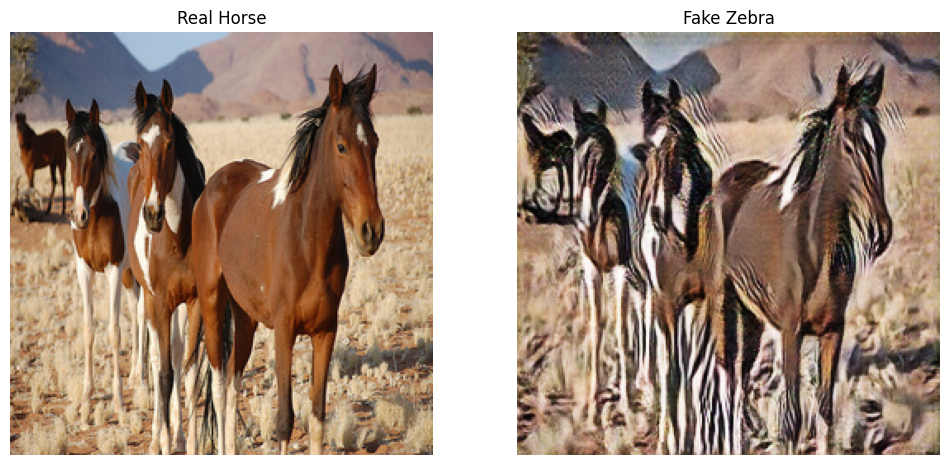

In [ ]:
# Generate images using the models
# Get some test images (no label to unpack)
real_X = next(iter(loader_X))
real_X = real_X.to(device)

# Generate fake zebras
with torch.no_grad():
    fake_Y = G_XtoY(real_X)

# Plot input and output
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Real horse
plt.subplot(1, 2, 1)
plt.title('Real Horse')
plt.imshow(denormalize(real_X[0]).permute(1, 2, 0).cpu().numpy())
plt.axis('off')

# Fake zebra
plt.subplot(1, 2, 2)
plt.title('Fake Zebra')
plt.imshow(denormalize(fake_Y[0]).permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.show()

In [ ]:
# Save multiple generated images after training
# Set models to eval mode
G_XtoY.eval()

# Create folder to save outputs
os.makedirs('generated_results', exist_ok=True)

# Get 10 horse images
real_X_batch = []
for _ in range(10):
    img = next(iter(loader_X))
    real_X_batch.append(img)

real_X_batch = torch.cat(real_X_batch, dim=0).to(device)

# Generate fake zebras
with torch.no_grad():
    fake_Y_batch = G_XtoY(real_X_batch)

# Denormalize
def denormalize(img):
    img = img * 0.5 + 0.5
    img = img.clamp(0, 1)
    return img

real_X_batch = denormalize(real_X_batch)
fake_Y_batch = denormalize(fake_Y_batch)

# Save real horses
vutils.save_image(real_X_batch, 'generated_results/real_horses.png', nrow=5)
# Save fake zebras
vutils.save_image(fake_Y_batch, 'generated_results/fake_zebras.png', nrow=5)

print(" Saved 10 real horses and their translated zebras!")

 Saved 10 real horses and their translated zebras!


In [ ]:
# Compute SSIM and PSNR between real and generated images
# Fix the SSIM function
def calculate_ssim(img1, img2):
    img1 = img1.permute(1, 2, 0).cpu().numpy()
    img2 = img2.permute(1, 2, 0).cpu().numpy()
    return ssim(img1, img2, channel_axis=2, data_range=1.0)

def calculate_psnr(img1, img2):
    img1 = img1.permute(1, 2, 0).cpu().numpy()
    img2 = img2.permute(1, 2, 0).cpu().numpy()
    return psnr(img1, img2, data_range=1.0)

# Now evaluate
ssim_scores = []
psnr_scores = []

for _ in range(10):
    real_X = next(iter(loader_X)).to(device)
    with torch.no_grad():
        fake_Y = G_XtoY(real_X)

    real_X_denorm = denormalize(real_X[0])
    fake_Y_denorm = denormalize(fake_Y[0])

    ssim_score = calculate_ssim(real_X_denorm, fake_Y_denorm)
    psnr_score = calculate_psnr(real_X_denorm, fake_Y_denorm)

    ssim_scores.append(ssim_score)
    psnr_scores.append(psnr_score)

# Print results
print(f"Average SSIM: {np.mean(ssim_scores):.4f}")
print(f"Average PSNR: {np.mean(psnr_scores):.4f} dB")

Average SSIM: 0.5927
Average PSNR: 18.5139 dB


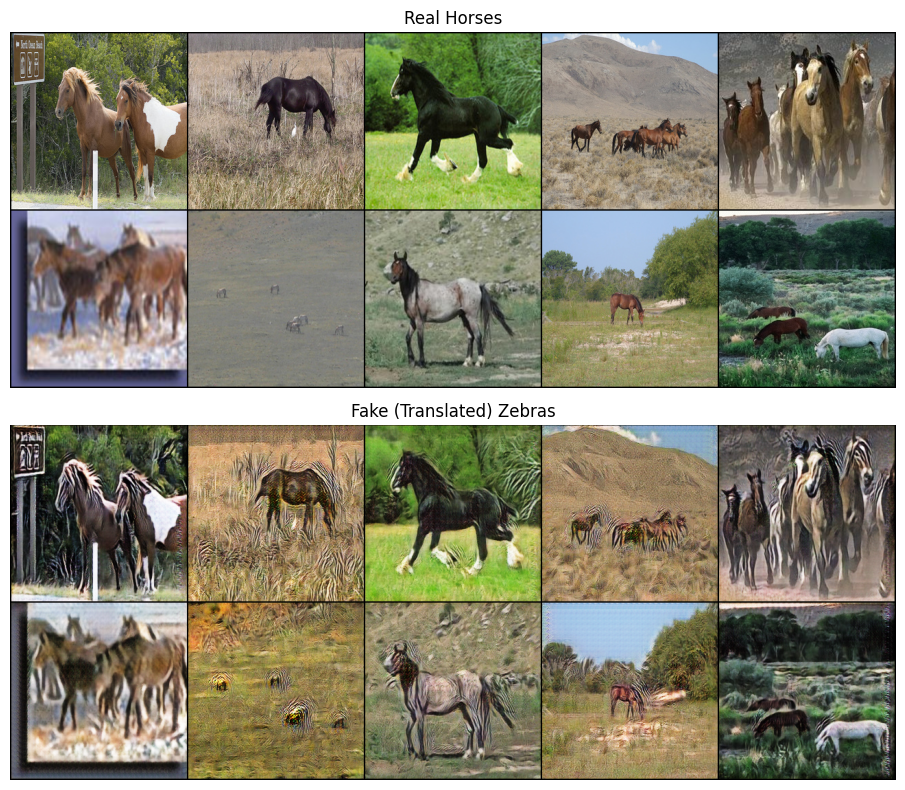

In [ ]:
# Compare Real vs Fake Visually
# Load images
real_horses = vutils.make_grid(real_X_batch, nrow=5, normalize=True)
fake_zebras = vutils.make_grid(fake_Y_batch, nrow=5, normalize=True)

plt.figure(figsize=(15,8))

# Real horses
plt.subplot(2, 1, 1)
plt.title('Real Horses')
plt.imshow(real_horses.permute(1, 2, 0).cpu().numpy())
plt.axis('off')

# Fake zebras
plt.subplot(2, 1, 2)
plt.title('Fake (Translated) Zebras')
plt.imshow(fake_zebras.permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.tight_layout()
plt.show()